*The following discusses a few points from Chapter 5 of Witten et al.'s **Data Mining: Practical Machine Learning Tools and Techniques** (4th ed).* Specifically, these notes discuss defining a confidence interval based on a classifier's performance on a dataset available (usually, data is scarce). They also discuss using statistical tests to evaluate the relative performance of classifiers. 


## Estimating classifier performance


When we develop a classification model, its performance (e.g., accuracy) will vary from data set to data set (even if the data sets were taken from the same population), and in general we'd like a way of estimating how well the model is expected to perform. One thing we can do is use the results obtained from a test set and define a confidence interval based on that.  

The idea is that applying the classifier to randomly selected data sets is a Bernouli process, like flipping a coin. If the probability of getting heads is $p$, then for any sequence of $N$ coin flips, the actual frequency of heads will be somewhere around $p$. If we were to record the values for multiple sequences of coin flips,  it turns out that the variance  of the values will be $p(1-p)/N$. For large $N$, the distribution will be approximately normal. 

Suppose a classifier on a given set yields accuracy f=75%. To standardize $f$ (yielding a $z$ score), we would use the following. 

$\frac{f - p}{\sqrt{p(1-p)/N}}$

To define an interval, we would need to choose a suitable value for $z$ (based upon whatever confidence level we are interested in, and then compute:

$P(-z < \frac{f - p}{\sqrt{p(1-p)/N}} < +z)$

Actually, what we are interested in is solving for $p$ (we treat the above as an equality and then solve for $p$). The details are omitted, but we are left with.  

$p = (f + \frac{z^2}{2N} \pm z\sqrt{\frac{f}{N}-\frac{f^2}{N}+\frac{z^2}{4N^2}})/(1+\frac{z^2}{N})$

A Python function computing confidence intervals based on this is given below. 

In [8]:
import math
from scipy.stats import norm,t, binom
import matplotlib
import matplotlib.pyplot as plt
import numpy as np;
import pandas as pd

In [9]:
wdbc_data = '../data-sets/wdbc.csv'

In [10]:
# defines interval level based on the above discussion. 
def confidence(f, N, c=0.9):
    z = norm.ppf(1-((1-c)/2))
    t1 = z*math.sqrt(f/N - (f*f)/N + (z*z)/(4*N*N))
    t2 = f + (z*z)/(2*N) 
    t3 = (1+(z*z)/N)
    return [(t2-t1)/t3, (t2+t1)/t3]

In [11]:
# Aside: we'll print out some z scores for some confidence levels. 
dist = norm(0,1)
x = np.linspace(0.0,0.99,20)
for i in x:
    half = i+(1-i)/2
    print("{0:.2f}\t{1:.4f}".format(i, dist.ppf(half)))

0.00	0.0000
0.05	0.0654
0.10	0.1310
0.16	0.1972
0.21	0.2643
0.26	0.3326
0.31	0.4024
0.36	0.4743
0.42	0.5488
0.47	0.6264
0.52	0.7080
0.57	0.7946
0.63	0.8876
0.68	0.9891
0.73	1.1019
0.78	1.2307
0.83	1.3841
0.89	1.5795
0.94	1.8655
0.99	2.5758


Below, we compare the manual calculations to what we get using a normal distribution from `scipy.stats`. Note that the use of a normal distribution will only be appropriate for a large value for $n$.  

In [12]:
dist = norm(0,1)
z = norm.ppf(0.9)

f = 0.75
c = 0.8
n = 1000

# compare the manual calculation to using norm.interval.
print(confidence(f,n,c))
print(norm.interval(c, loc=f, scale=math.sqrt(f*(1-f))/math.sqrt(n)))

[0.7320513138468852, 0.7671288454309665]
(0.7324516324736291, 0.7675483675263709)


In [13]:
n = 100
p = 0.75
print(confidence(p,n,c))
print(norm.interval(c, loc=p, scale=math.sqrt(p*(1-p))/math.sqrt(n)))

[0.6907697268228327, 0.8011510915140075]
(0.6945071893989329, 0.8054928106010671)


In [14]:
p = 0.75
c = 0.8
n = 10

print(confidence(p,n,c))
print(norm.interval(c, loc=p, scale=math.sqrt(p*(1-p))/math.sqrt(n)))

[0.5483172316247326, 0.881148427329997]
(0.5745163247362906, 0.9254836752637094)


## Using t-tests to compare classifiers

It's possible to use t-tests to compare 2 or more classifiers. Importantly, one should not use a standard paired t-test, as the this tends to falsely indicate that 2 models are different when they are not. Witten et al. instead recommend what they call the \emph{corrected resampled t-test}. They indicate that it is acceptable to use this test when compairing models on resampled data (multiple pairs of accuracy scores are obtained by repeatedly generating training test splits over the data), or else when cross validation is used. 

Below, we'll use the Wisconsin breast cancer data set and compare decision trees to logistic regression.

In [15]:
# We'll read in the data set using Pandas. 
df = pd.read_csv(wdbc_data, header=0)
print("shape:\t",df.shape)
df.head()

shape:	 (569, 32)


,id,radiusAvg,textureAvg,perimeterAvg,areaAvg,smoothnessAvg,compactnessAvg,concavityAvg,concavepointsAvg,symmetryAvg,...,textureWorst,perimeterWorst,areaWorst,smoothnessWorst,compactnessWorst,concavityWorst,concavepointsWorst,symmetryWorst,fractaldimWorst,c
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


We'll now create the classifiers and store the results of multiple stratified k-fold cross-validation runs. If there are $n$ runs and $k$ folds, we will have $n*k$ pairs of numbers.  

In [16]:
from sklearn import tree, linear_model
import sklearn.metrics as metrics
from sklearn.model_selection import StratifiedKFold
from scipy.stats import ttest_rel, ttest_ind
data = df.iloc[:].values

# extract X and y values from the data set; 
X = data[:, 1:-1]
y = data[:, -1]

# create the classifier objects; 
dtree = tree.DecisionTreeClassifier()
logr = linear_model.LogisticRegression(solver='liblinear')

repeats = 10;
cv = 10; 
scores = [] # to store scores of each run+fold. 

# for run and fold, fit the models and store performance on the test set. 
for i in range(repeats):
    k_fold = StratifiedKFold(n_splits=cv, shuffle=True)
    for train_indices, test_indices in k_fold.split(X,y):
        dtree.fit(X[train_indices], y[train_indices]) 
        logr.fit(X[train_indices],    y[train_indices])     
        predictedTree = dtree.predict(X[test_indices])
        predictedLogR = logr.predict(X[test_indices])
        scores.append(
        [metrics.accuracy_score(y[test_indices], predictedTree), metrics.accuracy_score(y[test_indices], predictedLogR
                                   )])
scores = np.array(scores);

# print out average accuracy over all of the runs and folds for each classifier.")
print("Accuracy: Tree={:.3f}+/-{:.3f} Reg={:.3f}+/-{:.3f}".format(np.mean(scores[:,0]),np.std(scores[:,0]),np.mean(scores[:,1]),np.std(scores[:,1]),))

# print out the results of simple paried t-test
(tval, pval) = ttest_rel(scores[:,0], scores[:,1])
print("\nt-value {}, p-value {}".format(tval, pval))

Accuracy: Tree=0.923+/-0.036 Reg=0.952+/-0.030

t-value -7.690228626789212, p-value 1.0992789213902389e-11


Below, following the textbook's discussion, we manually calculate the t-score based on our recorded accuracy scores and then the p-value.The results should be the same as using scipy's builtin  `ttest_rel`.

The t-statistic is calculated as  $\frac{\overline{d}}{\sqrt{\frac{1}{k}\sigma_d^2}}$, where  $\overline{d}$ is the mean of the differences between the paired accuracy values and $k$ is the degrees of freedom, which is the number of pairs - 1. 

In [17]:
# t-statistic based on simple differences of the two data sets. 
diff = scores[:,0]-scores[:,1]
variance = np.var(diff)
k = len(diff)-1 # note the text doesn't clearly indicate subtracting the 1 to obtain the degrees of freedom. 
tval = np.mean(diff)/math.sqrt(variance/k)
dist = t(k)
pval = dist.cdf(tval)*2
print("\nt-value {}, p-value {}".format(tval, pval))


t-value -7.690228626789212, p-value 1.0992789213902389e-11


The results above very likely indicate that the results of two classifiers are statistically significant (*note that when the jupyter notebook scripts are rerun, it is possible that the results will change*). However, the assumptions of the t-test are violated (for one, we're resampling the data set multiple times, and so the samples are not indpendent of each other). As such, the results of the t-test are not to be trusted. 

Witten et al. recommend using this corrected version of the statistic: $\frac{\overline{d}}{\sqrt{(\frac{1}{k}+\frac{n_2}{n_1})\sigma_d^2}}$. Here, $n_2$ and $n_1$ refer to the size of the test set and the training set (in this case, the ratio would be 1/9). We could do the same thing if we use the repeated holdout method rather than repeated cross-validation. Witten et al. indicate that the process and interpretation would be the same. 

The results of this corrected test could easily could be different.

In [18]:
# corrected resampled t-statistic (assumes we use repeated train/test splits or repeated cross-validation). 
diff = scores[:,0]-scores[:,1]
variance = np.var(diff)
foldcount = 10;
test_size = math.floor(data.shape[0]/foldcount);
train_size = math.floor(data.shape[0]-test_size);
tval = np.mean(diff)/math.sqrt(variance*(1/k+ test_size/train_size))
pval = dist.cdf(tval)*2
print("\nt-value {}, p-value {}".format(tval, pval))


t-value -2.2380467135509714, p-value 0.027458518568216482


Below, rather than use cross-validation, we just use repeated training/test splits. We again compare the results of the plain paired t-test vs the "corrected resampled t-test". 

In [19]:
# uncorrected paired t-test using repeated holdout method. 
from sklearn.model_selection import train_test_split
test_percent = 0.20
scores = []
k = 100;
for i in range(k):
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=test_percent, shuffle=True)
    dtree.fit(X_train, y_train) 
    logr.fit(X_train,  y_train)     
    predictedTree = dtree.predict(X_test)
    predictedLogR = logr.predict(X_test)
    scores.append(
        [metrics.accuracy_score(y_test, predictedTree), metrics.accuracy_score(y_test, predictedLogR
                                   )])
scores = np.array(scores);

# output results of simple paired t-test. 
print("Tree={:.3f}+/-{:.3f} Reg={:.3f}+/-{:.3f}".format(np.mean(scores[:,0]),np.std(scores[:,0]),np.mean(scores[:,1]),np.std(scores[:,1]),))
(tval, pval) = ttest_rel(scores[:,0], scores[:,1])
print("\nt-value {}, p-value {}".format(tval, pval))

Tree=0.929+/-0.023 Reg=0.953+/-0.019

t-value -9.676954526642609, p-value 5.544164615402578e-16


In [20]:
# corrected paired t-test using repeated holdout method
diff = scores[:,0]-scores[:,1]
variance = np.var(diff)
print("k:",k)
test_size = math.floor(data.shape[0]*test_percent);
train_size = math.floor(data.shape[0]-test_size);

tval = np.mean(diff)/math.sqrt(variance*(1/k+ test_size/train_size))
pval = dist.cdf(tval)*2
print("\nt-value {}, p-value {}".format(tval, pval))

k: 100

t-value -1.9154628598235999, p-value 0.0583191760320691


One question that you might have is this: Looking at how the t-statistic is computed ($\frac{\overline{d}}{\sqrt{\sigma_d^2/k}})$, won't the magnitude of the t-statistic be very large in realistic data mining scenarios?

Yes, that appears to be the case. Below we compare the plots of the uncorrected t-statistic and the corrected version. 

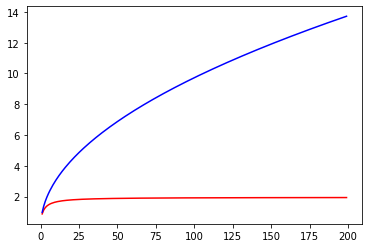

In [21]:
tvals = []
for k in range(1,200):
    tvals.append( [k, 
                   np.absolute(np.mean(diff)/math.sqrt(variance*(1/k+ test_size/train_size))),
                   np.absolute(np.mean(diff)/math.sqrt(variance*(1/k)))])
pltdata = np.array(tvals);
plt.plot(pltdata[:,0],pltdata[:,1],"r", pltdata[:,0],pltdata[:,2],"b")